In [ ]:
# Download data
!rm -rf sts2017.eval.v1.1.zip* STS2017.eval.v1.1
!wget http://alt.qcri.org/semeval2017/task1/data/uploads/sts2017.eval.v1.1.zip
!unzip sts2017.eval.v1.1.zip
!cp STS2017.eval.v1.1/STS.input.track5.en-en.txt input.txt

In [2]:
# Step 1. Preprocessing
## 1.1 Read data

with open('input.txt') as f:
    lines = [line.strip() for line in f]

print(lines[:10])

['A person is on a baseball team.\tA person is playing basketball on a team.', 'Our current vehicles will be in museums when everyone has their own aircraft.\tThe car needs to some work', 'A woman supervisor is instructing the male workers.\tA woman is working as a nurse.', 'A bike is next to a couple women.\tA child next to a bike.', 'The group is eating while taking in a breathtaking view.\tA group of people take a look at an unusual tree.', 'The boy is raising his hand.\tThe man is raising his hand.', 'A man with a gray beard is being shaved in front of a lecture hall\tA man with a beard is sitting in the grass.', 'The sky has very little to no clouds.\tThis Lady might be ready for Rock Climbing, or just watching the Clouds, above.', 'The young boy jumps barefoot outside in the front yard.\tThe teen rode his bike around the people walking in the courtyard.', 'There are dogs in the forest.\tThe dogs are alone in the forest.']


In [4]:
# 1.2 Preparing words
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [5]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

english_stopwords = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()

words = dict()
sentences = list()

for line in lines:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in english_stopwords:
                continue
            w = lemmatizer.lemmatize(w)
            words.setdefault(w, len(words))
            v.append(words[w])

    sentences.append((v1, v2))

In [17]:
print(list(words.items())[:10])
print(sentences[:10])

[('person', 0), ('baseball', 1), ('team', 2), ('playing', 3), ('basketball', 4), ('current', 5), ('vehicle', 6), ('museum', 7), ('everyone', 8), ('aircraft', 9)]
[([0, 1, 2], [0, 3, 4, 2]), ([5, 6, 7, 8, 9], [10, 11, 12]), ([13, 14, 15, 16, 17], [13, 18, 19]), ([20, 21, 22, 13], [23, 21, 20]), ([24, 25, 26, 27, 28], [24, 29, 30, 31, 32, 33]), ([34, 35, 36], [37, 35, 36]), ([37, 38, 39, 40, 41, 42, 43], [37, 39, 44, 45]), ([46, 47, 48], [49, 50, 51, 52, 53, 54, 48]), ([55, 34, 56, 57, 58, 41, 59], [60, 61, 20, 62, 29, 63, 64]), ([65, 66], [65, 67, 66])]


In [7]:
# Step 2. Graph construction
import numpy as np


In [18]:
# 2.1 Synonyms
from nltk.corpus import wordnet

synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in english_stopwords:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1

In [19]:
# 2.2 GoW(no)

window_graph = np.zeros((len(words), len(words)))

window_size = 3 # Parameter

for ss in sentences:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph[v1][v2] += 1
                window_graph[v2][v1] += 1
            window.append(v1)

In [20]:
# 2.3 Merge graphs

import tqdm
import numba

distances = 1 / (synonym_graph + window_graph)
np.fill_diagonal(distances, 0)

def floyd(dist):
    N = dist.shape[0]
    
    @numba.jit
    def helper(dist, N, k):
        for i in range(N):
            for j in range(N):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    for k in tqdm.trange(N):
        helper(dist, N, k)

floyd(distances)

C:\Users\satt-\AppData\Local\Temp\ipykernel_21476\4183238919.py:6: RuntimeWarning: divide by zero encountered in true_divide
  distances = 1 / (synonym_graph + window_graph)
100%|██████████| 762/762 [00:01<00:00, 693.76it/s]


In [24]:
# Step 3. Main part of this project (MDS)

import numpy.linalg as la

@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

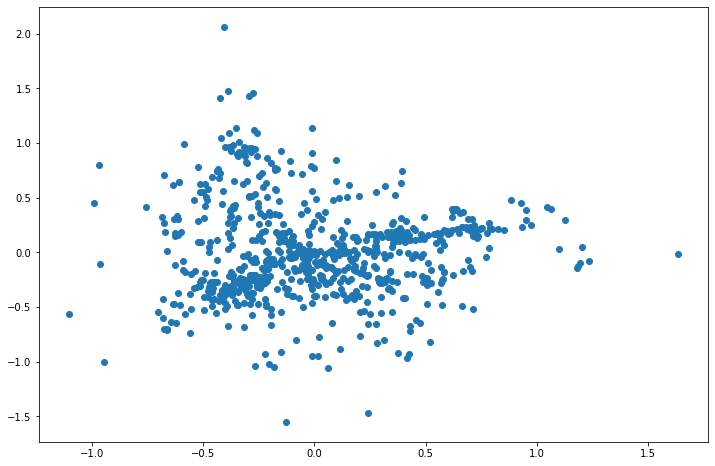

In [25]:
import matplotlib.pyplot as plt

word_to_vec = embed_graph(distances, 10)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

In [26]:
import scipy.spatial.distance as dist

for i, (s1, s2) in enumerate(sentences):
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = dist.cosine(v1, v2)
    print(i, "{:1.8f}".format(d), lines[i], sep='\t')

0	0.01728555	A person is on a baseball team.	A person is playing basketball on a team.
1	1.02594549	Our current vehicles will be in museums when everyone has their own aircraft.	The car needs to some work
2	0.42185389	A woman supervisor is instructing the male workers.	A woman is working as a nurse.
3	0.12899719	A bike is next to a couple women.	A child next to a bike.
4	0.94829794	The group is eating while taking in a breathtaking view.	A group of people take a look at an unusual tree.
5	0.19338828	The boy is raising his hand.	The man is raising his hand.
6	0.57466354	A man with a gray beard is being shaved in front of a lecture hall	A man with a beard is sitting in the grass.
7	0.67690305	The sky has very little to no clouds.	This Lady might be ready for Rock Climbing, or just watching the Clouds, above.
8	1.44741783	The young boy jumps barefoot outside in the front yard.	The teen rode his bike around the people walking in the courtyard.
9	0.00322628	There are dogs in the forest.	The

In [28]:
import pandas as pd
#reading csv files
train = pd.read_csv('Train.csv')
valid = pd.read_csv('Valid.csv')             

#train_test split
x_tr, y_tr = train['text'].values, train['label'].values
x_val, y_val = valid['text'].values, valid['label'].values

In [29]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(x_val_seq,y_val, batch_size=128)
print(val_acc)

OSError: No file or directory found at best_model.h5